In [1]:
import os
import sys
import numpy as np
from graph_tool.all import triangulation, label_components
import hdbscan
import graph_tool
import matplotlib.pyplot as plt
from scipy.linalg import norm
import shapely
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from HierarchicalGeoClustering.TreeClusters import *
from HierarchicalGeoClustering.Clustering import *


In [2]:

HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=40, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_AMOEBA_clus, noise = compute_AMOEBA(X_2, return_noise = True)

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:96: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return shapely.ops.cascaded_union(keep_triangles)
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:377: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  points_cluster_o = [p for p in points_cluster if
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:1086: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_points =all_points+[i for i in node.get_points(all_tag = iterative )]


/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:689: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  x_points_cluster =[j.x for j in cluster_points  ]
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/TreeClusters.py:690: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  y_points_cluster =[j.y for j in cluster_points  ]


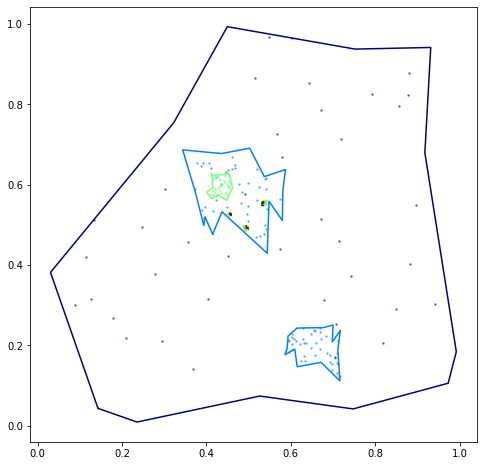

In [3]:
fig, axs = plt.subplots( figsize=(8,8))
HGC.visualize(axs, polygon=True)

In [4]:
 tree_AMOEBA = recursive_clustering_tree(dic_points,
                                         algorithm = 'amoeba',  # Algorithm to use
                                         return_noise = True,
                                         levels_clustering= 5,
                                                # verbose = True
                                                )

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/Clustering.py:77: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return cascaded_union(list(polygonize(lines)))


In [5]:
cluster_tree_AMOEBA = []
recursive_clustering([dic_points],  # Dictionary with Points
                4,  # levels to process
                cluster_tree_AMOEBA,  # to store the clusters
                level=0,  # current level
                algorithm= 'amoeba',
                return_noise = True,
                )

In [6]:
cluster_tree_Natural  = []
recursive_clustering([dic_points],  # Dictionary with Points
                4,  # levels to process
                cluster_tree_Natural,  # to store the clusters
                level=0,  # current level
                algorithm= 'natural_cities',
                return_noise = True,
                )

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/Clustering.py:169: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for num_pol, poly in enumerate( multy_pol):
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/Clustering.py:169: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for num_pol, poly in enumerate( multy_pol):
/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/Clustering.py:169: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for num_pol, poly in enumerate( multy_p

In [7]:
tree_clus_natural= get_tree_from_clustering(cluster_tree_Natural )

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/Clustering.py:77: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return cascaded_union(list(polygonize(lines)))


In [8]:
tree_clus_AMOEBA= get_tree_from_clustering(cluster_tree_AMOEBA )

In [9]:
all_level_clusters =[]
previus_level=[]
list_len = len(cluster_tree_Natural)-1
for level_num_clus, level_cluster in enumerate(cluster_tree_Natural):
    level_nodes=[]
    for cluster_te in level_cluster:
        node_l = NodeCluster(name= cluster_te['parent'])
        to_concat= [point_arr for point_arr in cluster_te['points']]
        if len(to_concat)>0:
            points_poly = np.concatenate(to_concat)
        else:
            points_poly = np.array([], dtype= np.float64).reshape(0,2)
        print('Shape noise',cluster_te['noise_points'].shape)
        print(points_poly.shape)
        
        points_poly = np.concatenate(
                               (points_poly,cluster_te['noise_points']),
                               axis=0
                          )



        if len(points_poly) <3:
            node_l.polygon_cluster = None
        else:
            node_l.polygon_cluster = get_alpha_shape(points_poly)


        ##### Es necesario que si es el último nivel todos los puntos sean
        ## considerados como ruido pues aunque se haya hecho la clusterizacion
        #  ya no se bajo al siguiente nivel
        ## 
        if level_num_clus==list_len:
            node_l.point_cluster_noise = shapely.geometry.MultiPoint(points_poly) 
        else:
            node_l.point_cluster_noise = shapely.geometry.MultiPoint(cluster_te['noise_points']) 

        pos=node_l.name.rfind('_L')
        if node_l.name[:pos]=='':
            node_l.parent = None
        else:
            lis_pa=[item  for item in previus_level if item.name == node_l.name[:pos]]
            node_l.parent= lis_pa[0]
        level_nodes.append(node_l)
    all_level_clusters.append(level_nodes)
    previus_level = level_nodes


Shape noise (125, 2)
(795, 2)
Shape noise (40, 2)
(281, 2)
Shape noise (48, 2)
(232, 2)
Shape noise (39, 2)
(121, 2)
Shape noise (4, 2)
(0, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (4, 2)
(5, 2)
Shape noise (3, 2)
(4, 2)
Shape noise (6, 2)
(5, 2)
Shape noise (35, 2)
(125, 2)
Shape noise (36, 2)
(85, 2)
Shape noise (32, 2)
(88, 2)
Shape noise (27, 2)
(54, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (4, 2)
(5, 2)
Shape noise (5, 2)
(0, 2)
Shape noise (8, 2)
(3, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (31, 2)
(90, 2)
Shape noise (5, 2)
(0, 2)
Shape noise (4, 2)
(0, 2)
Shape noise (5, 2)
(0, 2)
Shape noise (7, 2)
(40, 2)
Shape noise (8, 2)
(16, 2)
Shape noise (0, 2)
(13, 2)
Shape noise (6, 2)
(35, 2)
Shape noise (4, 2)
(36, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (4, 2)
(38, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (6, 2)
(34, 2)
Shape noise (9, 2)
(36, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (3, 2)
(41, 2)
Shape noise (4, 2)
(0, 2)
Shape noise (3, 2)
(0, 2)
Shape noise (5, 2)
(0, 2)
Shape

In [10]:
compute_AMOEBA(X_2,
                return_noise = True,

              )

([array([[0.49186131, 0.57794796],
         [0.54349512, 0.54080083],
         [0.39264655, 0.6539275 ],
         ...,
         [0.53256538, 0.55333759],
         [0.53259376, 0.55335384],
         [0.53256982, 0.55332924]]),
  array([[0.70556872, 0.17248922],
         [0.61136557, 0.2123826 ],
         [0.59608457, 0.21052557],
         [0.69283258, 0.17638632],
         [0.70846204, 0.18006144],
         [0.6688059 , 0.24307604],
         [0.68512825, 0.18190032],
         [0.60283505, 0.18865272],
         [0.60342823, 0.2038863 ],
         [0.60356808, 0.22827822],
         [0.70852541, 0.15592062],
         [0.65365491, 0.23860335],
         [0.63320074, 0.16211563],
         [0.64689656, 0.22888858],
         [0.69633144, 0.13846712],
         [0.60773882, 0.21608907],
         [0.64785294, 0.19495435],
         [0.71027296, 0.13208747],
         [0.62937826, 0.2429061 ],
         [0.68321491, 0.22399985],
         [0.63221666, 0.20505449],
         [0.65732883, 0.17600925],
    

In [11]:
def compute_AMOEBA_file(points_array, **kwargs):
    """The function obtains the AMOEBA algorithm on level basis
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    
    gr, pos_d =triangulation(points_arr, "delaunay")
    dis_d = gr.new_edge_property("double")
    for e in gr.edges():
        dis_d[e] =  norm(pos_d[e.target()].a - pos_d[e.source()].a)
    gr.edge_properties["dis"] = dis_d
    gr.vertex_properties["pos"] = pos_d
    global_edge_mean= np.nan_to_num(gr.edge_properties['dis'].get_array().mean())
    global_edge_std = np.nan_to_num(gr.edge_properties['dis'].get_array().std() )
    
    all_remove_level =[]
    all_keep_level = []
    for vert in gr.vertices():
        local_mean= np.mean([gr.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_edge_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if gr.edge_properties['dis'][ed] > tolerance + global_edge_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = gr.new_edge_property("bool", True)
    gr.edge_properties["level_n_tolerance"] = level_n
    
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        gr.edge_properties['level_n_tolerance'][i]= False
    for i in all_keep_level_flat:
        gr.edge_properties['level_n_tolerance'][i]= True
        
    gr.set_edge_filter(prop =  gr.edge_properties['level_n_tolerance'])
    
    
    ##### If the vertex should be keep
    gr.vertex_properties["level_n_r"] = gr.new_vertex_property("bool", False)
    for vert in gr.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['level_n_r'][vert]= True
        else: 
            gr.vertex_properties['level_n_r'][vert]= False
    ##  to not consider the noise points
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(gr)
    gr.set_vertex_filter(None)
    
    gr.vertex_properties["compo_level_n"] = gr.new_vertex_property("int", -1)
    
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    
    compo_level_res_n = gr.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    gr.vertex_properties["compo_level_res_n"] = compo_level_res_n
    
    for vert in gr.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['compo_level_n'][vert]= gr.vertex_properties["compo_level_res_n"][vert] 
        else: 
            # print('No edge')
            gr.vertex_properties['compo_level_n'][vert]= -1
    
    
    ####### get the points for each cluster 
    clusters_result_n= np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a))
    clusters=[]
    noise_level= None
    for clas in clusters_result_n :
        if clas != -1:
            clas_mask = ( gr.vertex_properties['compo_level_n'].a == clas)
            clusters.append(points_array[clas_mask])
        else:
            clas_mask = ( gr.vertex_properties['compo_level_n'].a == clas)
            noise_level= points_array[clas_mask]
    if ret_noise == True:
        return clusters, noise_level
    return clusters
        
    

In [12]:
res_file = compute_AMOEBA_file(X_2,
                return_noise = True,
                scale_points=False

              )

In [48]:
len(res_file[0][0])

839

In [49]:
len(res_file[0][1])

40

In [50]:
len(res_file[1])

41

In [38]:
res_Natural = compute_Natural_cities(X_2,
                return_noise = True,
                scale_points=False

              )

/Partition1/Cgeo/git/HierarchicalGeoClustering/HierarchicalGeoClustering/Clustering.py:169: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for num_pol, poly in enumerate( multy_pol):


In [13]:
def compute_AMOEBA_single(points_array, **kwargs):
    """The function obtains the AMOEBA algorithm on level basis
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    cur_lev = kwargs.get('level', 0)
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    gr, pos_d =triangulation(points_arr, "delaunay")
    dis_d = gr.new_edge_property("double")
    for e in gr.edges():
        dis_d[e] =  norm(pos_d[e.target()].a - pos_d[e.source()].a)
    gr.edge_properties["dis"] = dis_d
    gr.vertex_properties["pos"] = pos_d
    global_edge_mean= np.nan_to_num(gr.edge_properties['dis'].get_array().mean())
    global_edge_std = np.nan_to_num(gr.edge_properties['dis'].get_array().std() ) 
    all_remove_level =[]
    all_keep_level = []
    for vert in gr.vertices():
        local_mean= np.mean([gr.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_edge_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if gr.edge_properties['dis'][ed] > tolerance + global_edge_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = gr.new_edge_property("bool", True)
    gr.edge_properties["level_n_tolerance"] = level_n
    
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        # print(i)
        gr.edge_properties['level_n_tolerance'][i]= False
    # print(all_keep_level_flat)
    for i_k in all_keep_level_flat:
        # print(i_k)
        gr.edge_properties['level_n_tolerance'][i_k]= True
        
    gr.set_edge_filter(prop =  gr.edge_properties['level_n_tolerance'])
    
    
    ##### If the vertex should be keep
    gr.vertex_properties["level_n_r"] = gr.new_vertex_property("bool", False)
    for vert in gr.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['level_n_r'][vert]= True
        else: 
            gr.vertex_properties['level_n_r'][vert]= False
    ##  to not consider the noise points
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(gr)
    gr.set_vertex_filter(None)
    
    gr.vertex_properties["compo_level_n"] = gr.new_vertex_property("int", -1)
    
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    
    compo_level_res_n = gr.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    gr.vertex_properties["compo_level_res_n"] = compo_level_res_n
    
    for vert in gr.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['compo_level_n'][vert]= gr.vertex_properties["compo_level_res_n"][vert] 
        else: 
            # print('No edge')
            gr.vertex_properties['compo_level_n'][vert]= -1
    
    
    ##### Now with the get the vertices in the graph that are in the
    ## connected components   
    dic_bool_arr_n={}
    clusters_result_n= np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a))
    ######### The AMOEBA algorithm creates clusters of lenght less than 3 elements
    ## This create a problem when a polygon mos be obtained. Therefore,
    #if the number of point is less than 3 such cluster will be consider noise
    for i in np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a)):
        clus_i_dic = gr.new_vertex_property("int", -1)
        clus_i_dic.a = gr.vertex_properties['compo_level_n'].a == i
        if i == -1:
            gr.vertex_properties["level_n_clus_"+ 'noise']= clus_i_dic
        else:
            gr.vertex_properties["level_n_clus_"+ str(i)] = clus_i_dic
    ################### Here is where the difference should hapen or the create 
    ### a new or use the same graph
    
    return gr

        
    

In [14]:
res_file[1]

array([[0.70659246, 0.25260835],
       [0.17776467, 0.26782282],
       [0.51439052, 0.86436437],
       [0.7929648 , 0.825943  ],
       [0.39482264, 0.51638653],
       [0.30231951, 0.59026253],
       [0.20861747, 0.21755247],
       [0.67149106, 0.78600723],
       [0.87861853, 0.82344608],
       [0.9408088 , 0.30246484],
       [0.85668538, 0.79591744],
       [0.2940457 , 0.21203033],
       [0.71358747, 0.460255  ],
       [0.57385909, 0.44014849],
       [0.89551135, 0.55015148],
       [0.3570099 , 0.45674046],
       [0.58014584, 0.66780529],
       [0.67122889, 0.5147385 ],
       [0.24700757, 0.49529607],
       [0.12643714, 0.3160355 ],
       [0.56704869, 0.72671597],
       [0.64232433, 0.85356952],
       [0.36708557, 0.14098794],
       [0.71902971, 0.71442586],
       [0.13321294, 0.51273513],
       [0.45166855, 0.42276988],
       [0.27876882, 0.37662558],
       [0.74219789, 0.37193523],
       [0.87991266, 0.87834931],
       [0.84975274, 0.29161008],
       [0.

In [15]:
grap_single= compute_AMOEBA_single(X_2,
                return_noise = True,
                scale_points=False

              )

In [16]:
grap_single.vertex_properties['compo_level_n'].a

PropertyArray([-1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
               -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
               -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
                0, -1,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
                1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0

In [17]:
####### get the points for each cluster 
clusters_result_n= np.nan_to_num(np.unique(grap_single.vertex_properties['compo_level_n'].a))
clusters=[]
noise_level= None
for clas in clusters_result_n :
    if clas != -1:
        clas_mask = ( grap_single.vertex_properties['compo_level_n'].a == clas)
        clusters.append(X_2[clas_mask])
    else:
        clas_mask = ( grap_single.vertex_properties['compo_level_n'].a == clas)
        noise_level= X_2[clas_mask]


In [18]:
clusters[0] == res_file[0][0]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [19]:
def build_delaunay_from_arr(points_array, **kwargs):
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    gr, pos = triangulation(points_arr, "delaunay")
    dis = gr.new_edge_property("double")
    dis = gr.new_edge_property("double")
    for e in gr.edges():
        dis[e] =  norm(pos[e.target()].a - pos[e.source()].a)
    gr.edge_properties["dis"] = dis
    gr.vertex_properties["pos"] = pos
    return gr

def compute_AMOEBA_graph_arr(points_array, **kwargs):
    
    """The function obtains the result of the  AMOEBA algorithm as a graph 
    analisys
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    
    
    gr = build_delaunay_from_arr(points_array, **kwargs)
    
    ##### here is the iterative 
    compute_AMOEBA_graph_graph(gr, **kwargs)
    


In [20]:
    
def compute_AMOEBA_graph_graph(graph, **kwargs):
    """The function obtains the result of the  AMOEBA algorithm as a graph 
    analisys
    
    :param graph-tool graph: a Graph class object from graph-tool
    (Obtained from delaunay triangulation or some other triangulation 
    has to be conected in order to make the evaluation on the edges)
    
    :returns: list with numpy arrays for all the clusters obtained
    """

    cur_lev = kwargs.get('level', 1)
    component_to_get_s= kwargs.get('component_to_get_s', '')
    edges_keep_s = kwargs.get('edges_keep_s', '')
    verbose = kwargs.get('verbose', False)
    
    graph.set_edge_filter(None)
    graph.set_vertex_filter(None)
    
    if verbose:
        print('Component to get: ' , component_to_get_s)
        print('Edges to keep: ',  edges_keep_s)
    
    
    ##########
    if component_to_get_s != '':
        component_to_get = graph.vertex_properties[component_to_get_s]
        graph.set_vertex_filter(component_to_get)
    if edges_keep_s != '':
        edges_keep = graph.edge_properties[edges_keep_s]
        graph.set_edge_filter(edges_keep)
    ##### The mean and the standar deviation can not be compute using all the 
    ## edges there for it has to be in a loop
    
    dis_lev = graph.get_edges(eprops=[graph.edge_properties['dis']])[:,2]
    global_mean = dis_lev.mean()
    global_edge_std  = dis_lev.std() 
    all_remove_level = []
    all_keep_level =  []
    if verbose:
        print('The global mean:', global_mean)
        print('The global std:', global_edge_std)
    for vert in graph.vertices():
        
        local_mean= np.mean([graph.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if graph.edge_properties['dis'][ed] > tolerance + global_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = graph.new_edge_property("bool", True)
    graph.edge_properties['l_'+str(cur_lev)+'_tol'] = level_n
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        graph.edge_properties['l_'+str(cur_lev)+'_tol'][i]= False
    for i in all_keep_level_flat:
        graph.edge_properties['l_'+str(cur_lev)+'_tol'][i]= True
        
    graph.set_edge_filter(prop = graph.edge_properties['l_'+str(cur_lev)+'_tol'])
    
    ##### If the vertex should be keep
    graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'] = graph.new_vertex_property("bool", False)
    for vert in graph.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'][vert]= True
        else: 
            graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'][vert]= False
    ##  to not consider the noise points
    graph.set_vertex_filter(prop =  graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(graph)
    graph.set_vertex_filter(None)
    
    
    if verbose:
        print('Set vertex property:' , component_to_get_s +'_compo_l_'+ str(cur_lev))
        print('and filter using such property')
            
    graph.vertex_properties[component_to_get_s +'_compo_l_'+ str(cur_lev)] = graph.new_vertex_property("int", -1)
    
    graph.set_vertex_filter(prop =  graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'])
    
    
    compo_level_res_n = graph.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)+'_res'] = compo_level_res_n
    
    for vert in graph.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            graph.vertex_properties[component_to_get_s +'_compo_l_'+ str(cur_lev)][vert]= graph.vertex_properties[component_to_get_s +'_compo_l_'+str(cur_lev)+'_res' ][vert] 
        else: 
            # print('No edge')
            graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)][vert]= -1
    
    
    ##### Now with the get the vertices in the graph that are in the
    ## connected components   
    dic_bool_arr_n={}
    clusters_result_n= np.nan_to_num(np.unique(graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a))
    if verbose:
        print(clusters_result_n)
        
    for i in np.nan_to_num(np.unique(graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a)):
        clus_i_dic = graph.new_vertex_property("bool", 0)
        clus_i_dic.a = graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a == i
        if verbose:
            print('Level', str(cur_lev)  )
            print('Points in cluster ', str(i), sum(clus_i_dic.a)  )
        if i == -1:
            graph.vertex_properties[component_to_get_s+'_l_'+str(cur_lev)+ '_noise']= clus_i_dic
        else:
            graph.vertex_properties[component_to_get_s+'_l_'+str(cur_lev)+ '_clus_'+ str(i)] = clus_i_dic
    ################### Here is where the difference should hapen or the create 
    ### a new or use the same graph
    
    # return graph




In [21]:
gra_dela=build_delaunay_from_arr(X_2, scale_points=False)

In [22]:
compute_AMOEBA_graph_graph(gra_dela, level=1, verbose = True)

Component to get:  
Edges to keep:  
The global mean: 0.010233375989875407
The global std: 0.03770297858442538
Set vertex property: _compo_l_1
and filter using such property
[-1  0  1]
Level 1
Points in cluster  -1 41
Level 1
Points in cluster  0 839
Level 1
Points in cluster  1 40


In [23]:
gra_dela.properties

{('e',
  'dis'): <EdgePropertyMap object with value type 'double', for Graph 0x7f748f565790, at 0x7f748f565f10>,
 ('v',
  'pos'): <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f748f565790, at 0x7f748f565950>,
 ('e',
  'l_1_tol'): <EdgePropertyMap object with value type 'bool', for Graph 0x7f748f565790, at 0x7f748f5ba4d0>,
 ('v',
  'l_1_tol_r'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f748f565790, at 0x7f748f5ba510>,
 ('v',
  '_compo_l_1'): <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f748f565790, at 0x7f748f5ba910>,
 ('v',
  '_compo_l_1_res'): <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f748f565790, at 0x7f748f5ba750>,
 ('v',
  '_l_1_noise'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f748f565790, at 0x7f748f5baa50>,
 ('v',
  '_l_1_clus_0'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f748f565790, at 0x7f748f58e050>,
 ('v',
  '_l_1_clus_1'): <VertexPropert

In [24]:
compute_AMOEBA_graph_graph(gra_dela,
                           level=2,
                           component_to_get_s= '_l_1_clus_3' ,
                           edges_keep_s= 'l_1_tol',
                           verbose = True)

Component to get:  _l_1_clus_3
Edges to keep:  l_1_tol


KeyError: ('v', '_l_1_clus_3')